In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.rc('font', family='Malgun Gothic') 


In [2]:
# datetime을 index로 옮겨주는 함수
def datetime_revise(df):    
    # python datetime에서는 시간을 0~23시까지밖에 인식을 못하기 때문에 1을 빼준다.
    df.index = pd.to_datetime(df['datetime']) + pd.to_timedelta(df['hour'], unit='hours')
    df.drop(['year', 'month', 'day', 'datetime', 'avg_temp', 'mini_temp', 'max_temp'], axis=1, inplace=True)
    return df

In [3]:
# 시계열 분석을 위해 target값만을 뽑음
def make_df(df, colname):
    df = df.query(f'supplys == "{colname}"')
    return df

In [4]:
# upsamplingm downsampling해줄 수 있도록 하는 함수
def set_freq(df, freq='m'):
    tmp =  pd.DataFrame(df.resample(freq).sum())
    return tmp[tmp['target'] != 0.0]

In [5]:
total = pd.read_csv('data/no_outlier_data.csv')
total = datetime_revise(total)
total


,supplys,weekday,hour,target
2013-01-01 01:00:00,A,1,1,2497.129
2013-01-01 02:00:00,A,1,2,2363.265
2013-01-01 03:00:00,A,1,3,2258.505
2013-01-01 04:00:00,A,1,4,2243.969
2013-01-01 05:00:00,A,1,5,2344.105
...,...,...,...,...
2018-12-31 20:00:00,H,0,20,681.033
2018-12-31 21:00:00,H,0,21,669.961
2018-12-31 22:00:00,H,0,22,657.941
2018-12-31 23:00:00,H,0,23,610.953


In [6]:
# 공급사 이름
supply_name_list = [n for n in total['supplys'].unique().tolist()]
supply_name_list

['A', 'B', 'C', 'D', 'E', 'G', 'H']

In [7]:
hour_time_series = [set_freq(make_df(total, col), freq='h') for col in supply_name_list]
A_df = hour_time_series[0]
A_df

,weekday,hour,target
2013-01-01 01:00:00,1,1,2497.129
2013-01-01 02:00:00,1,2,2363.265
2013-01-01 03:00:00,1,3,2258.505
2013-01-01 04:00:00,1,4,2243.969
2013-01-01 05:00:00,1,5,2344.105
...,...,...,...
2018-12-31 20:00:00,0,20,3040.868
2018-12-31 21:00:00,0,21,2973.577
2018-12-31 22:00:00,0,22,2840.272
2018-12-31 23:00:00,0,23,2692.385


## 1. 시간 단위 ACF, PACF

In [8]:
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt

<AxesSubplot:xlabel='lag', ylabel='ACF'>

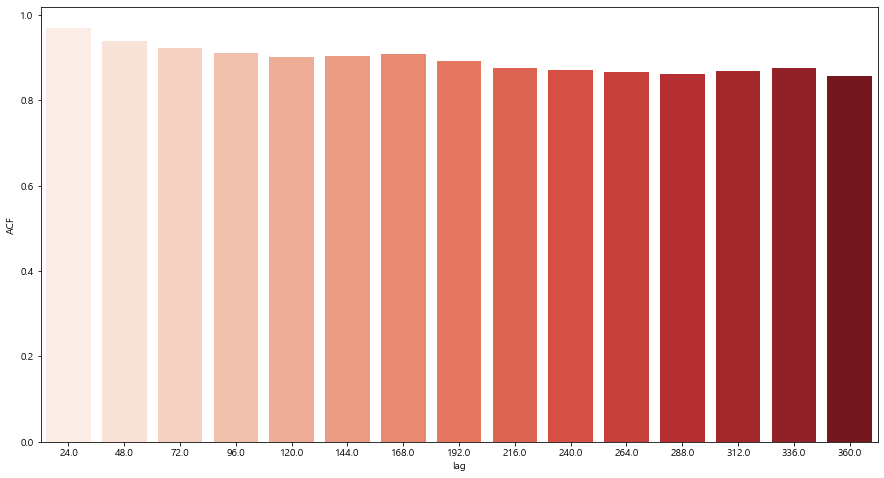

In [9]:
A_df_target = hour_time_series[0]['target']

# 360시간까지의 acf 계산
a_acf  = sts.acf(A_df_target, nlags=360)

# 24시간 주기로 acf 그래프를 그림
acf_graph_24 = pd.DataFrame(columns=['lag', 'ACF'])
for hour, acf in enumerate(a_acf):
    if hour > 0 and hour % 24 == 0:
        acf_graph_24 = acf_graph_24.append({'lag' : hour, 'ACF' : acf}, ignore_index=True)

plt.figure(figsize=(15, 8))
sns.barplot(data=acf_graph_24, x='lag', y='ACF', palette='Reds', )

In [10]:
# # 12시간, 24시간만다 매우 높은 양의 상관계수를 찍는 모습이다.(특히 24시간)

# fig = plt.figure(figsize=(40, 20))
# ax1 = fig.add_subplot(1, 1, 1)

# sgt.plot_acf(A_df_target, lags = 50, zero = False, ax=ax1)
# ax1.set_title("ACF in A", fontdict={'fontsize' : 20})


# plt.show()

In [11]:
# 24시간, 28시간, 72시간, 168시간 순으로 높은 걸 볼 수 있다.
acf_graph_all = pd.DataFrame(columns=['lag', 'ACF'])
for hour, acf in enumerate(a_acf[:200]):
    acf_graph_all = acf_graph_all.append({'lag' : hour, 'ACF' : acf}, ignore_index=True)

acf_graph_all.sort_values(by='ACF', ascending=False).reset_index()[:20]

,index,lag,ACF
0,0,0.0,1.000000
1,1,1.0,0.983721
2,24,24.0,0.970492
3,23,23.0,0.956478
4,25,25.0,0.954732
5,2,2.0,0.945622
6,48,48.0,0.939852
7,47,47.0,0.926578
8,49,49.0,0.925012
9,72,72.0,0.923633


<AxesSubplot:xlabel='lag', ylabel='ACF'>

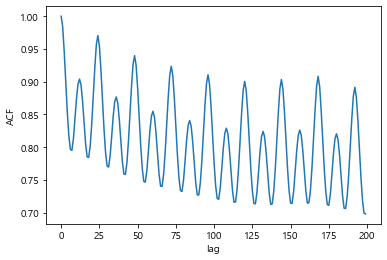

In [12]:
# 위의 그래프 시각화
sns.lineplot(data=acf_graph_all, x='lag', y='ACF')


## 회귀모형 구축(A사 대상)
- 요일별, 시간별로 다 나누어서 구축

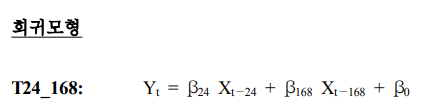

In [13]:
# t-24, t-168시간 전 데이터를 변수러 줌
A_df.insert(2, 't-24', A_df['target'].shift(24))
A_df.insert(3, 't-168', A_df['target'].shift(168))


In [14]:
A_df

,weekday,hour,t-24,t-168,target
2013-01-01 01:00:00,1,1,NaN,NaN,2497.129
2013-01-01 02:00:00,1,2,NaN,NaN,2363.265
2013-01-01 03:00:00,1,3,NaN,NaN,2258.505
2013-01-01 04:00:00,1,4,NaN,NaN,2243.969
2013-01-01 05:00:00,1,5,NaN,NaN,2344.105
...,...,...,...,...,...
2018-12-31 20:00:00,0,20,2965.860,2418.847,3040.868
2018-12-31 21:00:00,0,21,2877.140,2366.832,2973.577
2018-12-31 22:00:00,0,22,2748.745,2271.333,2840.272
2018-12-31 23:00:00,0,23,2685.433,2160.702,2692.385


In [15]:
hour_list = A_df['hour'].unique().tolist()
weekday_list = sorted(A_df['weekday'].unique().tolist())
len(hour_list)
hour_list

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [16]:
weekday_list

[0, 1, 2, 3, 4, 5, 6]

In [17]:
# 요일별, 시간대별로 168개 회귀모형 만들기 위해 요일, 시간대별 일치하는 것 끼리 사전작업

df_list = []

for hour in hour_list:
    weekday_list_tmp = []
    for weekday in weekday_list:
        tmp_df = A_df[(A_df['hour'] == hour) & (A_df['weekday'] == weekday)]
        tmp_df.dropna(inplace=True)
        tmp_df = tmp_df.drop(['weekday', 'hour'], axis=1)
        
        weekday_list_tmp.append(tmp_df)
    df_list.append(weekday_list_tmp)



In [18]:
#월요일 1시의 data
df_list[0][0]

,t-24,t-168,target
2013-01-14 01:00:00,2153.929,2491.065,2134.433
2013-01-21 01:00:00,2046.689,2134.433,1857.393
2013-01-28 01:00:00,2515.809,1857.393,2392.729
2013-02-04 01:00:00,1955.081,2392.729,1948.409
2013-02-11 01:00:00,2194.497,1948.409,2323.681
...,...,...,...
2018-12-03 01:00:00,1406.063,1372.878,1141.832
2018-12-10 01:00:00,2334.173,1141.832,2205.711
2018-12-17 01:00:00,2002.717,2205.711,1770.592
2018-12-24 01:00:00,1373.501,1770.592,1749.318


In [19]:
# 회귀모형 제작
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

def nmae(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [20]:
# MAPE table
mape_table = pd.DataFrame(columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'], index=hour_list)
r2_table = pd.DataFrame(columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'], index=hour_list)

# 시간 단위, 요일 단위로 모델을 제작한다.
lr_models_list = []
for hour, hour_df_list in zip(hour_list, df_list):
    lr_models_list_weekday = []
    for weekday, hour_weekday in zip(weekday_list, hour_df_list):
        
        # train, test 분리
        X, y = hour_weekday.iloc[:, :-1], hour_weekday.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        
        # 회귀 모형
        lr_model = LinearRegression(fit_intercept=True)
        lr_model.fit(X_train, y_train)
        
        lr_models_list_weekday.append(lr_model)

        y_pred = lr_model.predict(X_test)
        
        #R2, MAPE SCORE 확인하기 위해 생성
        mape_table.iloc[hour-1, weekday] = round(MAPE(y_test, y_pred), 2)
        r2_table.iloc[hour-1, weekday] = round(r2_score(y_test, y_pred), 2)
        
   
    lr_models_list.append(lr_models_list_weekday)
    

In [21]:
mape_table

,MON,TUE,WED,THU,FRI,SAT,SUN
1,6.62,7.14,7.48,6.57,6.2,5.82,6.17
2,8.19,9.19,8.72,7.83,7.69,6.89,7.25
3,8.98,9.25,9.46,7.89,8.72,7.28,8.21
4,8.37,9.75,9.08,7.9,8.64,7.71,8.28
5,7.36,8.4,8.01,6.91,7.74,7.51,7.13
6,6.65,8.86,7.2,6.58,7.64,7.88,7.1
7,6.42,8.68,7.77,6.44,7.62,9.36,6.81
8,5.93,7.33,7.38,6.16,7.56,9.01,5.85
9,7.86,6.84,6.29,5.15,6.23,9.02,5.34
10,8.87,6.44,5.44,4.71,5.49,8.55,5.19


In [22]:
r2_table

,MON,TUE,WED,THU,FRI,SAT,SUN
1,0.97,0.96,0.97,0.98,0.97,0.98,0.98
2,0.96,0.95,0.97,0.97,0.96,0.98,0.97
3,0.96,0.95,0.97,0.97,0.96,0.98,0.97
4,0.97,0.95,0.97,0.98,0.96,0.98,0.97
5,0.97,0.96,0.98,0.98,0.96,0.98,0.98
6,0.97,0.95,0.97,0.97,0.95,0.97,0.97
7,0.97,0.95,0.97,0.97,0.95,0.96,0.96
8,0.97,0.95,0.97,0.98,0.94,0.95,0.96
9,0.97,0.96,0.97,0.98,0.95,0.96,0.97
10,0.97,0.96,0.98,0.98,0.96,0.97,0.98


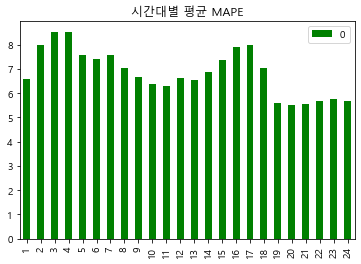

In [23]:
mean_by_hour = pd.DataFrame(round(mape_table.mean(axis=1), 2))

mean_by_hour.plot.bar(color='green', )
plt.title('시간대별 평균 MAPE')
plt.show()

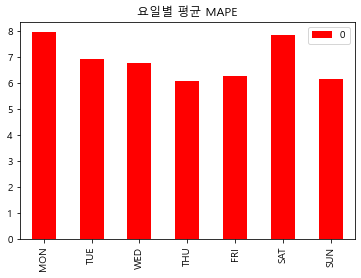

In [24]:
mean_by_hour = pd.DataFrame(round(mape_table.mean(axis=0), 2))

mean_by_hour.plot.bar(color='red', )
plt.title('요일별 평균 MAPE')
plt.show()

### 예시

In [25]:
# 요일(weekday)가 월요일(0)이면서 시간(hour)이 1시

mon_1hour = A_df[(A_df['hour'] == 1) & (A_df['weekday'] == 1)]
mon_1hour.dropna(inplace=True)

In [26]:
mon_1hour

,weekday,hour,t-24,t-168,target
2013-01-08 01:00:00,1,1,2491.065,2497.129,2524.977
2013-01-15 01:00:00,1,1,2134.433,2524.977,2247.465
2013-01-22 01:00:00,1,1,1857.393,2247.465,1921.081
2013-01-29 01:00:00,1,1,2392.729,1921.081,2217.057
2013-02-05 01:00:00,1,1,1948.409,2217.057,2128.889
...,...,...,...,...,...
2018-11-27 01:00:00,1,1,1372.878,1330.407,1406.050
2018-12-04 01:00:00,1,1,1141.832,1406.050,1119.376
2018-12-11 01:00:00,1,1,2205.711,1119.376,2152.555
2018-12-18 01:00:00,1,1,1770.592,2152.555,1898.804


In [27]:
mon_1hour_final = mon_1hour.drop(['weekday', 'hour'], axis=1)
mon_1hour_final

,t-24,t-168,target
2013-01-08 01:00:00,2491.065,2497.129,2524.977
2013-01-15 01:00:00,2134.433,2524.977,2247.465
2013-01-22 01:00:00,1857.393,2247.465,1921.081
2013-01-29 01:00:00,2392.729,1921.081,2217.057
2013-02-05 01:00:00,1948.409,2217.057,2128.889
...,...,...,...
2018-11-27 01:00:00,1372.878,1330.407,1406.050
2018-12-04 01:00:00,1141.832,1406.050,1119.376
2018-12-11 01:00:00,2205.711,1119.376,2152.555
2018-12-18 01:00:00,1770.592,2152.555,1898.804


In [28]:
# 회귀모형 제작

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [30]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 


In [31]:
def nmae(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [32]:
X, y = mon_1hour_final.iloc[:, :-1], mon_1hour_final.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_test.shape)

(234, 2) (78,)


In [33]:

lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print(f"r2_score : {r2_score(y_test, y_pred)}")
print(f"MAPE : {MAPE(y_test, y_pred)}")
print(f"NMAE : {nmae(y_test, y_pred)}")



r2_score : 0.9599841991071889
MAPE : 7.142901847950044
NMAE : 0.07142901847950044


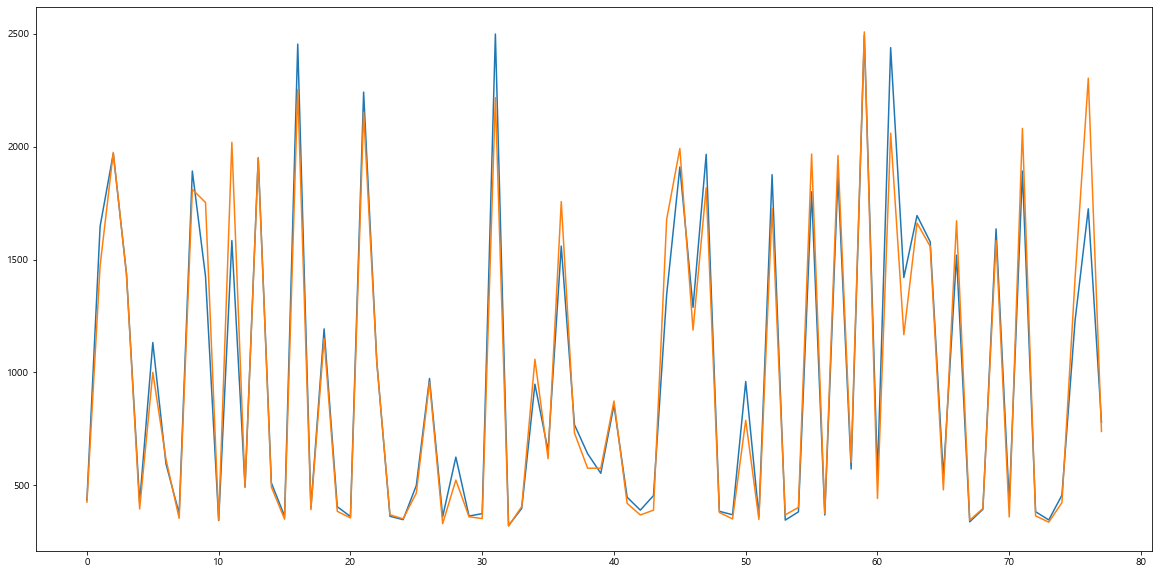

In [34]:
plt.figure(figsize=(20,10))
plt.plot(y_pred)
plt.plot(np.array(y_test))

## 데이터 탐색(여기서부터는 볼 필요 X)

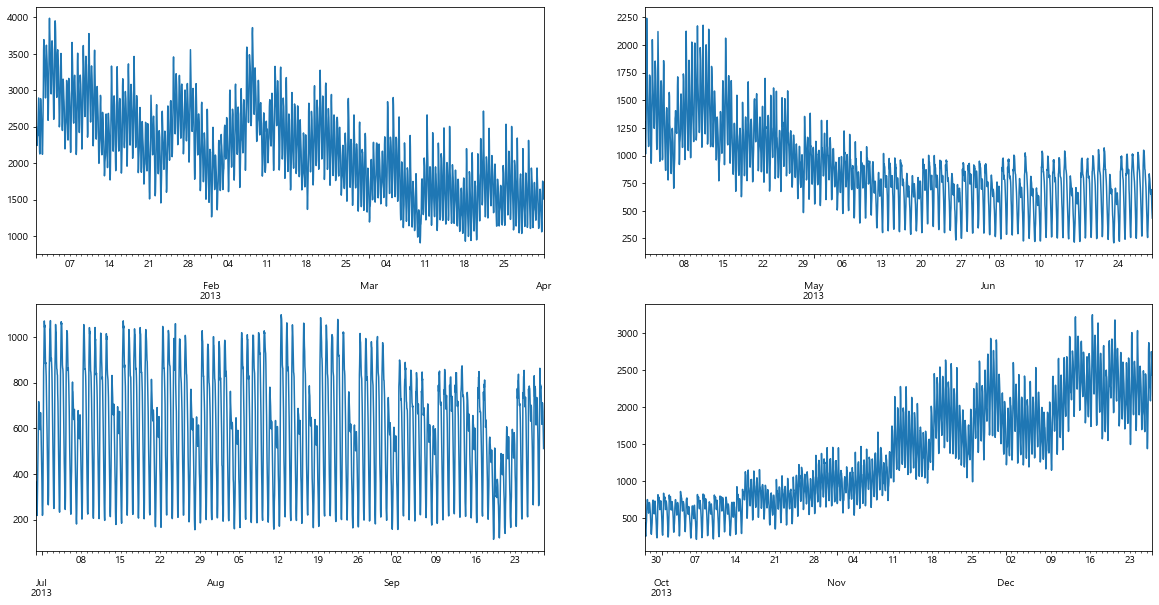

In [10]:
import seaborn as sns
# grid = sns.FacetGrid(data=date_db, col='고객사코드')
plt.figure(figsize=(20, 10))
for i in range(4):
    ax1 = plt.subplot(2, 2, i+1)
    tmp_db = A_df['target'][2160*(i):2160*(i+1)]
    tmp_db.plot(ax=ax1)
#     plt.title(f'{top_10_list[i]}')

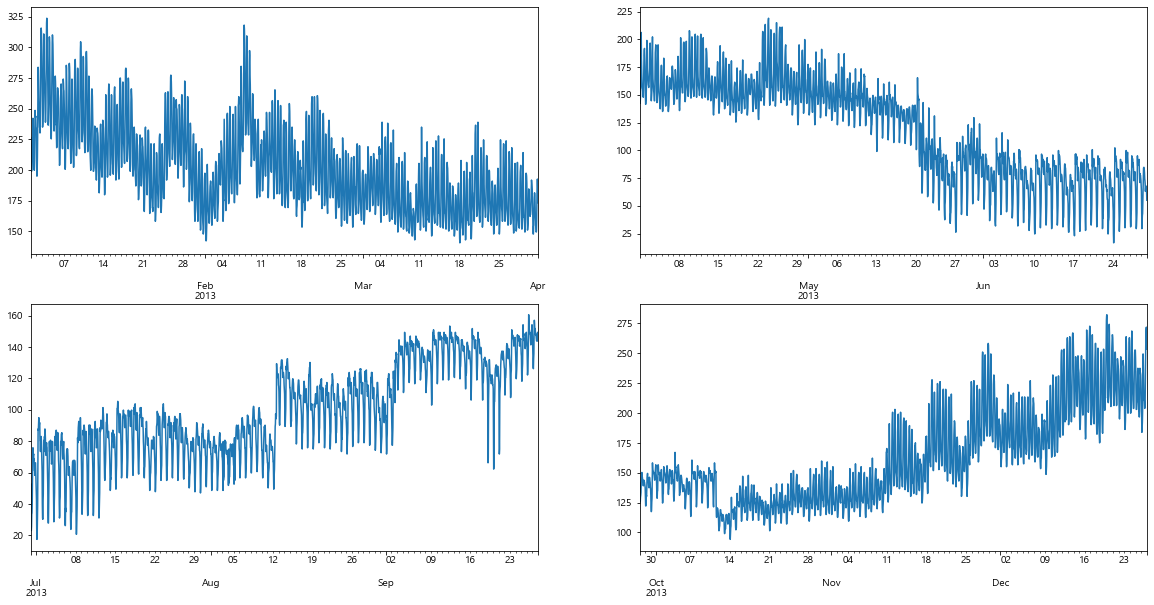

In [11]:
B_df = hour_time_series[2]

plt.figure(figsize=(20, 10))
for i in range(4):
    ax1 = plt.subplot(2, 2, i+1)
    tmp_db = B_df['target'][2160*(i):2160*(i+1)]
    tmp_db.plot(ax=ax1)
#     plt.title(f'{top_10_list[i]}')

In [12]:
temperature = pd.read_csv('data/temperature_hour.csv')
temperature['Unnamed: 0'] = pd.to_datetime(temperature['Unnamed: 0'])
temperature = temperature.set_index('Unnamed: 0')
temperature.index.name = None
temperature

,temp
2013-01-01 01:00:00,-8.5
2013-01-01 02:00:00,-8.4
2013-01-01 03:00:00,-8.1
2013-01-01 04:00:00,-8.2
2013-01-01 05:00:00,-8.2
...,...
2018-12-31 19:00:00,-3.1
2018-12-31 20:00:00,-3.7
2018-12-31 21:00:00,-4.6
2018-12-31 22:00:00,-5.4


In [13]:
tem_target = pd.DataFrame()
temperature['t_year'] = -(temperature['temp'].shift(8760))
tem_target['t_year'] = temperature['t_year']
tem_target['rol_3'] = temperature['t_year'].rolling(3).mean()
tem_target['rol_7'] = temperature['t_year'].rolling(7).mean()
tem_target['rol_14'] = temperature['t_year'].rolling(14).mean()


tem_target['t_year_target'] = A_df['target'].shift(8760)

minmax_rol = (tem_target['rol_14'] - tem_target['rol_14'].min()) / (tem_target['rol_14'].max() - tem_target['rol_14'].min())
minmax_target = (tem_target['t_year_target'] - tem_target['t_year_target'].min()) / (tem_target['t_year_target'].max() - tem_target['t_year_target'].min())
a = 0.1

tem_target['target x temp'] = (minmax_rol * a)  + (minmax_target * (1-a))
tem_target['target'] = A_df['target']


tem_target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52559 entries, 2013-01-01 01:00:00 to 2018-12-31 23:00:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   t_year         43782 non-null  float64
 1   rol_3          43749 non-null  float64
 2   rol_7          43690 non-null  float64
 3   rol_14         43592 non-null  float64
 4   t_year_target  43799 non-null  float64
 5   target x temp  43592 non-null  float64
 6   target         52559 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


In [14]:
tem_target.corr()

,t_year,rol_3,rol_7,rol_14,t_year_target,target x temp,target
t_year,1.000000,0.996851,0.979796,0.952138,0.828127,0.851679,0.760935
rol_3,0.996851,1.000000,0.990711,0.963160,0.837479,0.861504,0.769576
rol_7,0.979796,0.990711,1.000000,0.984123,0.851115,0.876385,0.783173
rol_14,0.952138,0.963160,0.984123,1.000000,0.881921,0.906270,0.814885
t_year_target,0.828127,0.837479,0.851115,0.881921,1.000000,0.998518,0.905405
target x temp,0.851679,0.861504,0.876385,0.906270,0.998518,1.000000,0.905889
target,0.760935,0.769576,0.783173,0.814885,0.905405,0.905889,1.000000


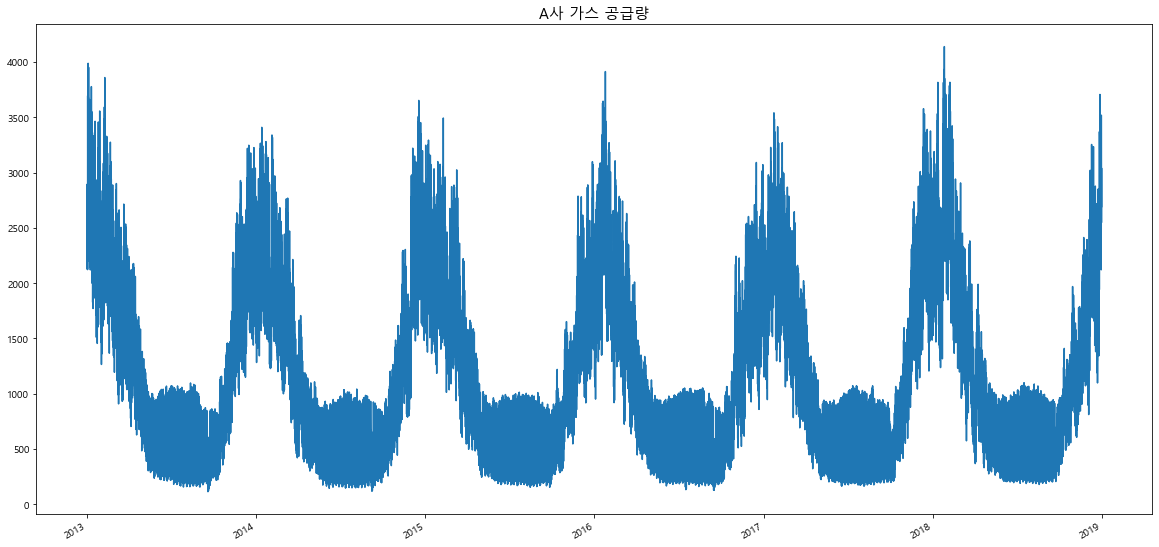

In [30]:
plt.figure(figsize=(20,10))
tem_target['target'].plot()
plt.title('A사 가스 공급량', fontdict={'fontsize' : 15})
plt.show()


## 평균

In [10]:
data = total.reset_index()
data['index'] = data['index'].dt.strftime('%m-%d-%H')
# data['month'] = data['index'].dt.month
# data['day'] = data['index'].dt.day.values
# data['hour'] = data['index'].dt.hour.values
# data['month'] = data['month'].astype('object')
# data['day']=data['day'].astype('object')
# data['hour'] = data['hour'].astype('object')
# data.info()

# cols = ['month', 'day', 'hour']
# data['combined'] = data[cols].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
# data['combined'] = data['combined'].astype(int)

data

,index,supplys,avg_temp,mini_temp,max_temp,target
0,01-01-01,A,-3.2,-9.1,2.6,2497.129
1,01-01-02,A,-3.2,-9.1,2.6,2363.265
2,01-01-03,A,-3.2,-9.1,2.6,2258.505
3,01-01-04,A,-3.2,-9.1,2.6,2243.969
4,01-01-05,A,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...,...
367915,12-31-20,H,-3.2,-9.9,4.0,681.033
367916,12-31-21,H,-3.2,-9.9,4.0,669.961
367917,12-31-22,H,-3.2,-9.9,4.0,657.941
367918,12-31-23,H,-3.2,-9.9,4.0,610.953


In [ ]:
data_2 = data.groupby(['supplys', 'index']).mean().reset_index()
data_2

In [159]:
data_list = []
for name in supply_name_list:
    tmp = data[data['supplys'] == name].reset_index(drop=True)
    data_list.append(tmp)


In [160]:
data_df=pd.DataFrame()
for data in data_list:
    data_df = data_df.append(data.iloc[:15120//7], ignore_index=True)

data_df

,index,supplys,avg_temp,mini_temp,max_temp,target
0,01-01-01,A,-3.2,-9.1,2.6,2497.129
1,01-01-02,A,-3.2,-9.1,2.6,2363.265
2,01-01-03,A,-3.2,-9.1,2.6,2258.505
3,01-01-04,A,-3.2,-9.1,2.6,2243.969
4,01-01-05,A,-3.2,-9.1,2.6,2344.105
...,...,...,...,...,...,...
15115,03-31-20,H,7.3,2.4,13.7,422.220
15116,03-31-21,H,7.3,2.4,13.7,448.324
15117,03-31-22,H,7.3,2.4,13.7,411.892
15118,03-31-23,H,7.3,2.4,13.7,376.140


In [161]:
test_data = pd.read_csv('test.csv')
test_data['공급량'] = data_df['target']
test_data

,일자|시간|구분,공급량
0,2019-01-01 01 A,2497.129
1,2019-01-01 02 A,2363.265
2,2019-01-01 03 A,2258.505
3,2019-01-01 04 A,2243.969
4,2019-01-01 05 A,2344.105
...,...,...
15115,2019-03-31 20 H,422.220
15116,2019-03-31 21 H,448.324
15117,2019-03-31 22 H,411.892
15118,2019-03-31 23 H,376.140


In [162]:
test_data.to_csv('mean.csv', index=False)

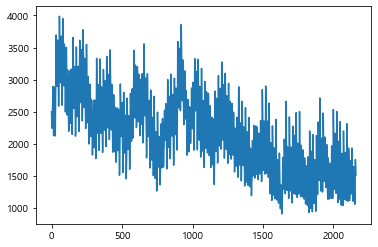

In [171]:
plt.plot(test_data.iloc[:2160, -1])

<AxesSubplot:>

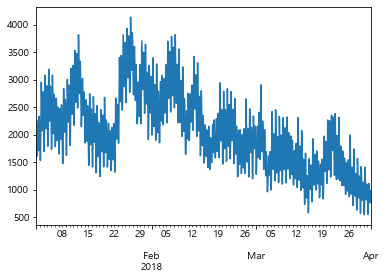

In [183]:
A_df.iloc[-8760:-8760+2160,-1].plot()

## 1. 시간 단위 ACF, PACF

In [ ]:
hour_time_series = [set_freq(make_df(total, col), freq='h') for col in colname]
hour_time_series[1].head()

,target
2013-01-01 01:00:00,2169.093
2013-01-01 02:00:00,2051.733
2013-01-01 03:00:00,1923.253
2013-01-01 04:00:00,1927.253
2013-01-01 05:00:00,2047.333


### ACF / PACF

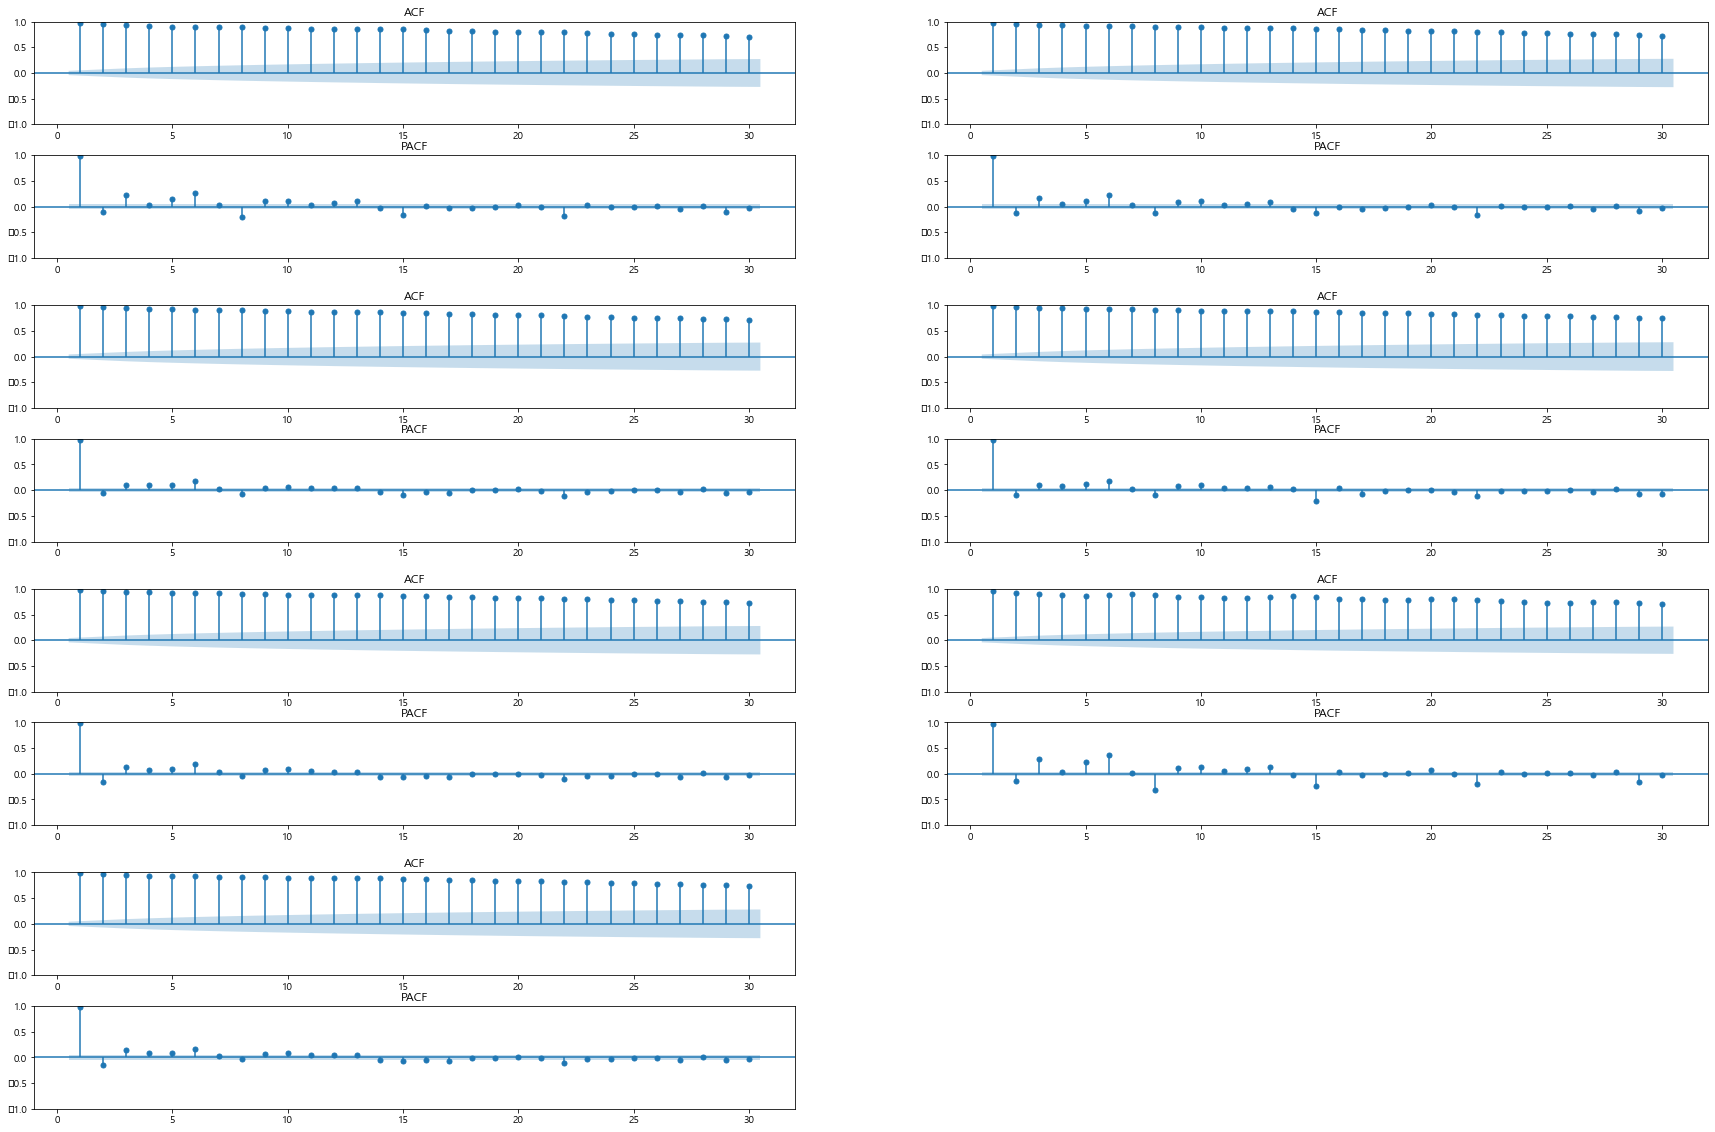

In [ ]:
import matplotlib.gridspec as gridspec

# Grid하기 위한 작업
fig = plt.figure(figsize=(30, 20))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)

for idx, t_df in enumerate(day_time_series):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[idx], wspace=0.3, hspace=0.3)
    
    # Grid내부에 acf, pacf를 그릴 subplot 생성
    ax1 = plt.Subplot(fig, inner[0])
    ax2 = plt.Subplot(fig, inner[1])
    
    # acf draw
    sgt.plot_acf(t_df['target'], lags = 30, zero = False, ax=ax1)
    ax1.set_title("ACF")
    
    # pacf draw
    sgt.plot_pacf(t_df['target'], lags = 30, zero = False, method = ('ols'), ax=ax2)
    ax2.set_title("PACF")
    
    fig.add_subplot(ax1)
    fig.add_subplot(ax2)

fig.show()

#### A사만 실험적으로 진행

<AxesSubplot:xlabel='lag', ylabel='ACF'>

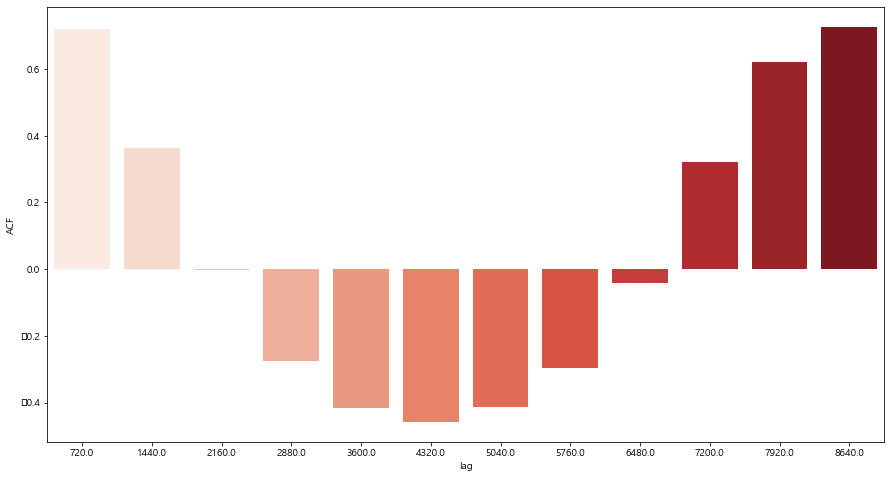

In [21]:
# 그리고 일주일 주기로 ACF가 다시 증가된 상관계수를 갖는다
A_df = hour_time_series[0]
a_acf  = sts.acf(A_df, nlags=8760)

acf_graph_24 = pd.DataFrame(columns=['lag', 'ACF'])
for hour, acf in enumerate(a_acf):
    if hour > 0 and hour % 720 == 0:
        acf_graph_24 = acf_graph_24.append({'lag' : hour, 'ACF' : acf}, ignore_index=True)

plt.figure(figsize=(15, 8))
sns.barplot(data=acf_graph_24, x='lag', y='ACF', palette='Reds', )

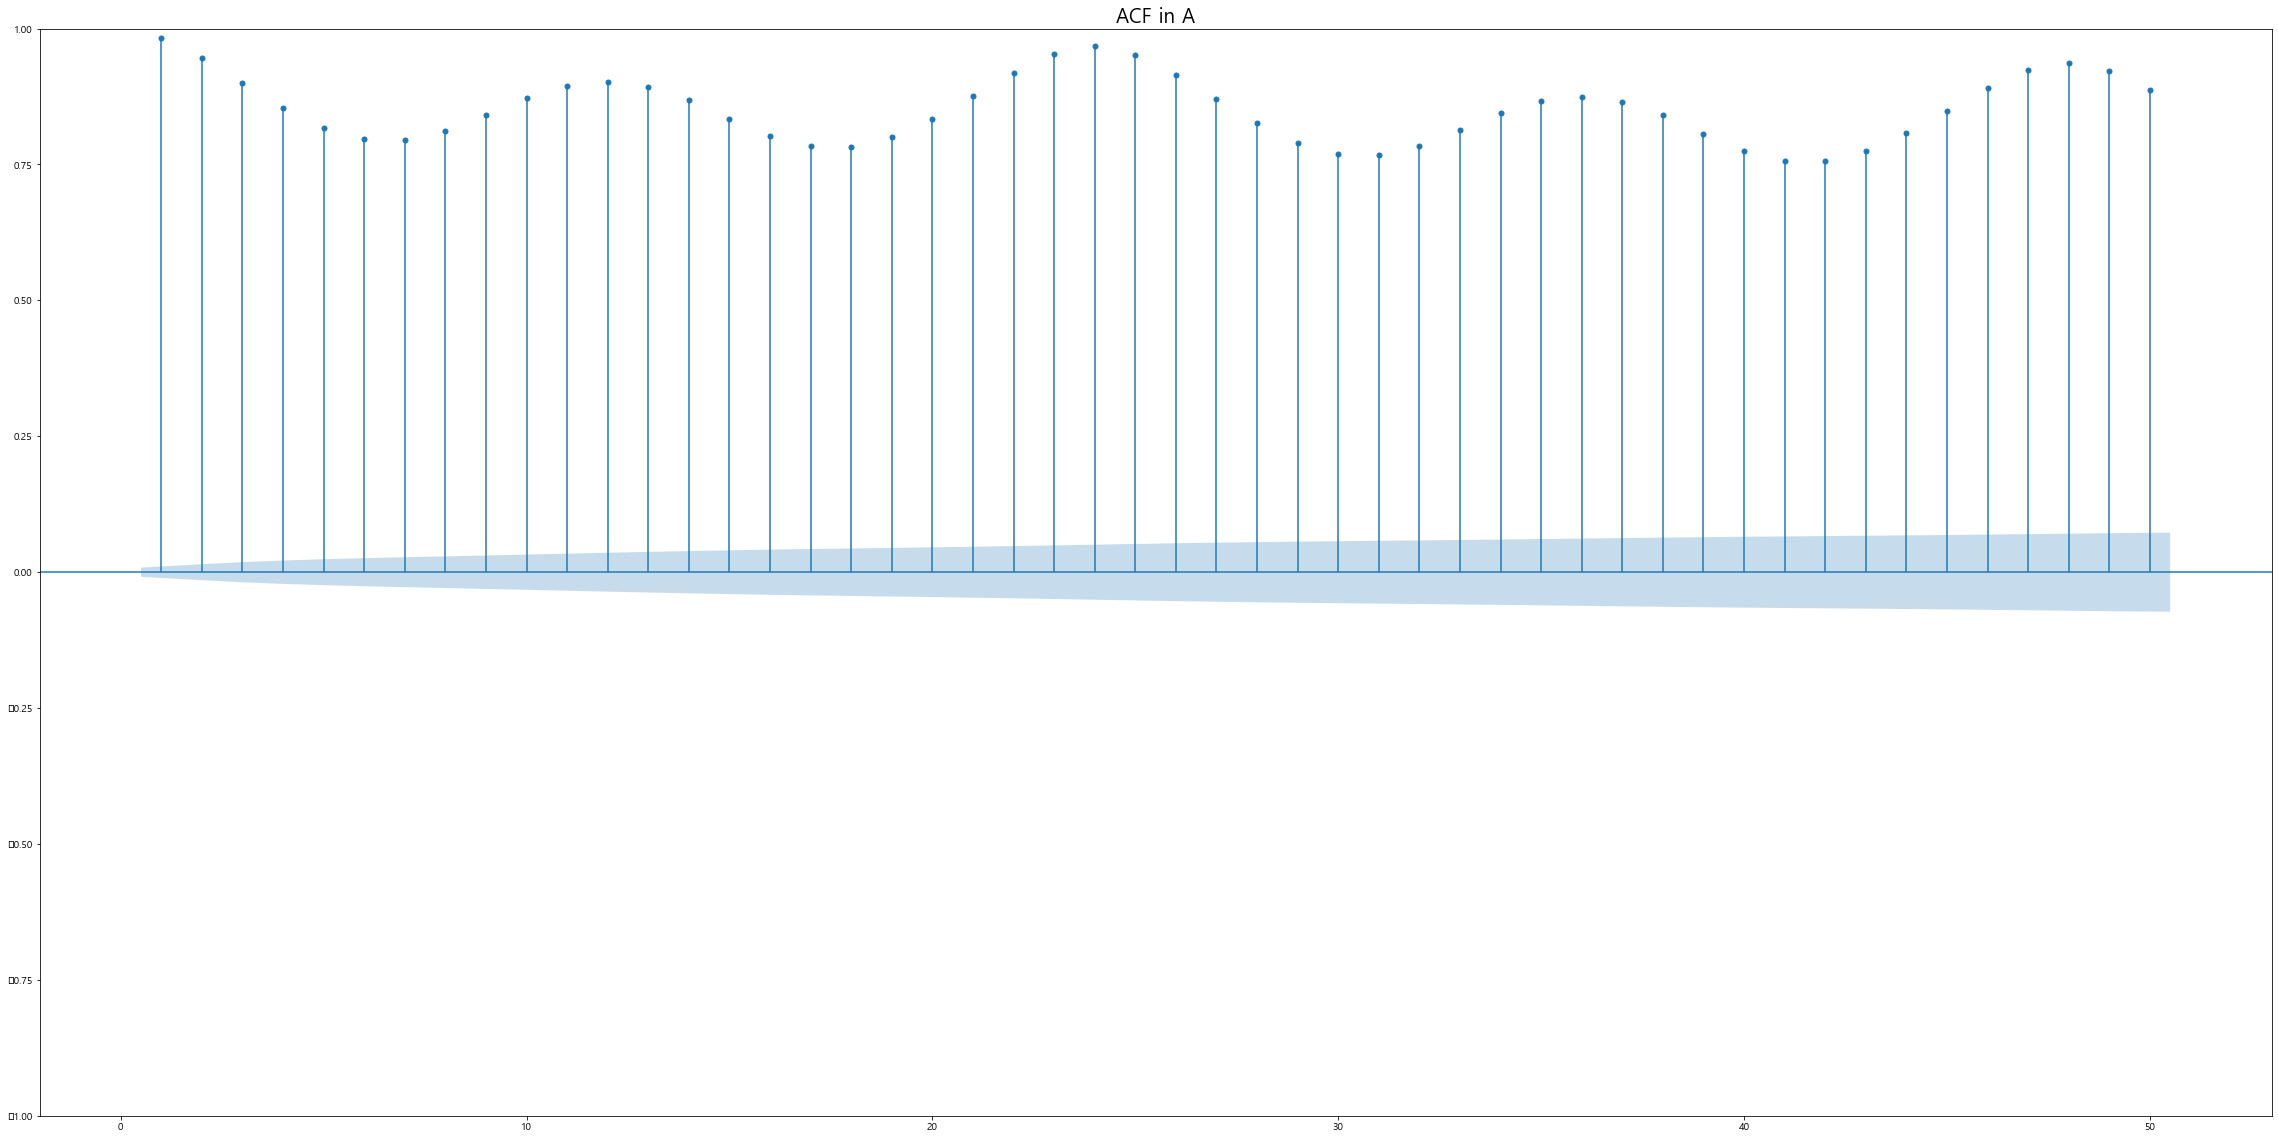

In [17]:
# 12시간, 24시간만다 매우 높은 양의 상관계수를 찍는 모습이다.(특히 24시간)

fig = plt.figure(figsize=(40, 20))
ax1 = fig.add_subplot(1, 1, 1)

sgt.plot_acf(A_df, lags = 50, zero = False, ax=ax1)
ax1.set_title("ACF in A", fontdict={'fontsize' : 20})


plt.show()

In [18]:
# 24시간, 28시간, 72시간, 168시간 순으로 높은 걸 볼 수 있다.
acf_graph_all = pd.DataFrame(columns=['lag', 'ACF'])
for hour, acf in enumerate(a_acf[:200]):
    acf_graph_all = acf_graph_all.append({'lag' : hour, 'ACF' : acf}, ignore_index=True)

acf_graph_all.sort_values(by='ACF', ascending=False).reset_index()[:30]

,index,lag,ACF
0,0,0.0,1.000000
1,1,1.0,0.983612
2,24,24.0,0.967659
3,23,23.0,0.953770
4,25,25.0,0.951952
5,2,2.0,0.945434
6,48,48.0,0.937124
7,47,47.0,0.923867
8,49,49.0,0.922323
9,72,72.0,0.920942


<AxesSubplot:xlabel='lag', ylabel='ACF'>

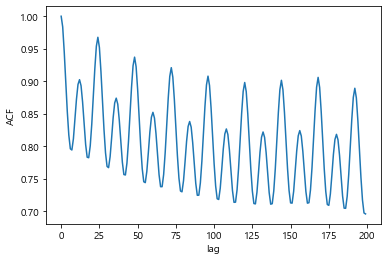

In [19]:
# 위의 그래프 시각화
sns.lineplot(data=acf_graph_all, x='lag', y='ACF')


## 회귀모형

In [31]:
A_df_24 = A_df.shift(24)
A_df_168 = A_df.shift(168)
A_df_168

,target
2013-01-01 01:00:00,NaN
2013-01-01 02:00:00,NaN
2013-01-01 03:00:00,NaN
2013-01-01 04:00:00,NaN
2013-01-01 05:00:00,NaN
...,...
2018-12-31 20:00:00,2418.847
2018-12-31 21:00:00,2366.832
2018-12-31 22:00:00,2271.333
2018-12-31 23:00:00,2160.702


In [32]:
A_df_reg = pd.DataFrame()
A_df_reg['t_24'] = A_df_24.target
A_df_reg['t_168'] = A_df_168.target

A_df_reg['y'] = A_df.target

In [33]:
A_df

,target
2013-01-01 01:00:00,2497.129
2013-01-01 02:00:00,2363.265
2013-01-01 03:00:00,2258.505
2013-01-01 04:00:00,2243.969
2013-01-01 05:00:00,2344.105
...,...
2018-12-31 20:00:00,3040.868
2018-12-31 21:00:00,2973.577
2018-12-31 22:00:00,2840.272
2018-12-31 23:00:00,2692.385


In [34]:
A_df_reg_final = A_df_reg.dropna()

In [35]:
A_df_reg_final

,t_24,t_168,y
2013-01-08 01:00:00,2491.065,2497.129,2524.977
2013-01-08 02:00:00,2249.113,2363.265,2255.009
2013-01-08 03:00:00,2148.961,2258.505,2120.113
2013-01-08 04:00:00,2230.049,2243.969,2180.161
2013-01-08 05:00:00,2456.953,2344.105,2377.865
...,...,...,...
2018-12-31 20:00:00,2965.860,2418.847,3040.868
2018-12-31 21:00:00,2877.140,2366.832,2973.577
2018-12-31 22:00:00,2748.745,2271.333,2840.272
2018-12-31 23:00:00,2685.433,2160.702,2692.385


In [36]:
#sklearn LR

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [38]:
# 20% test
from sklearn.model_selection import train_test_split
train, test = A_df_reg_final.iloc[:, :-1],  A_df_reg_final.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(train, test, shuffle=False, test_size=.25)
y_train.shape

(39312, 1)

In [39]:
lr_model = LinearRegression(fit_intercept=True)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

In [40]:
a_pred=y_pred.copy()

In [41]:
# 높은 r2_score
r2_score(y_test, y_pred)

0.9500824008377665

In [42]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 


In [43]:
MAPE(y_test, y_pred)

y    9.521576
dtype: float64

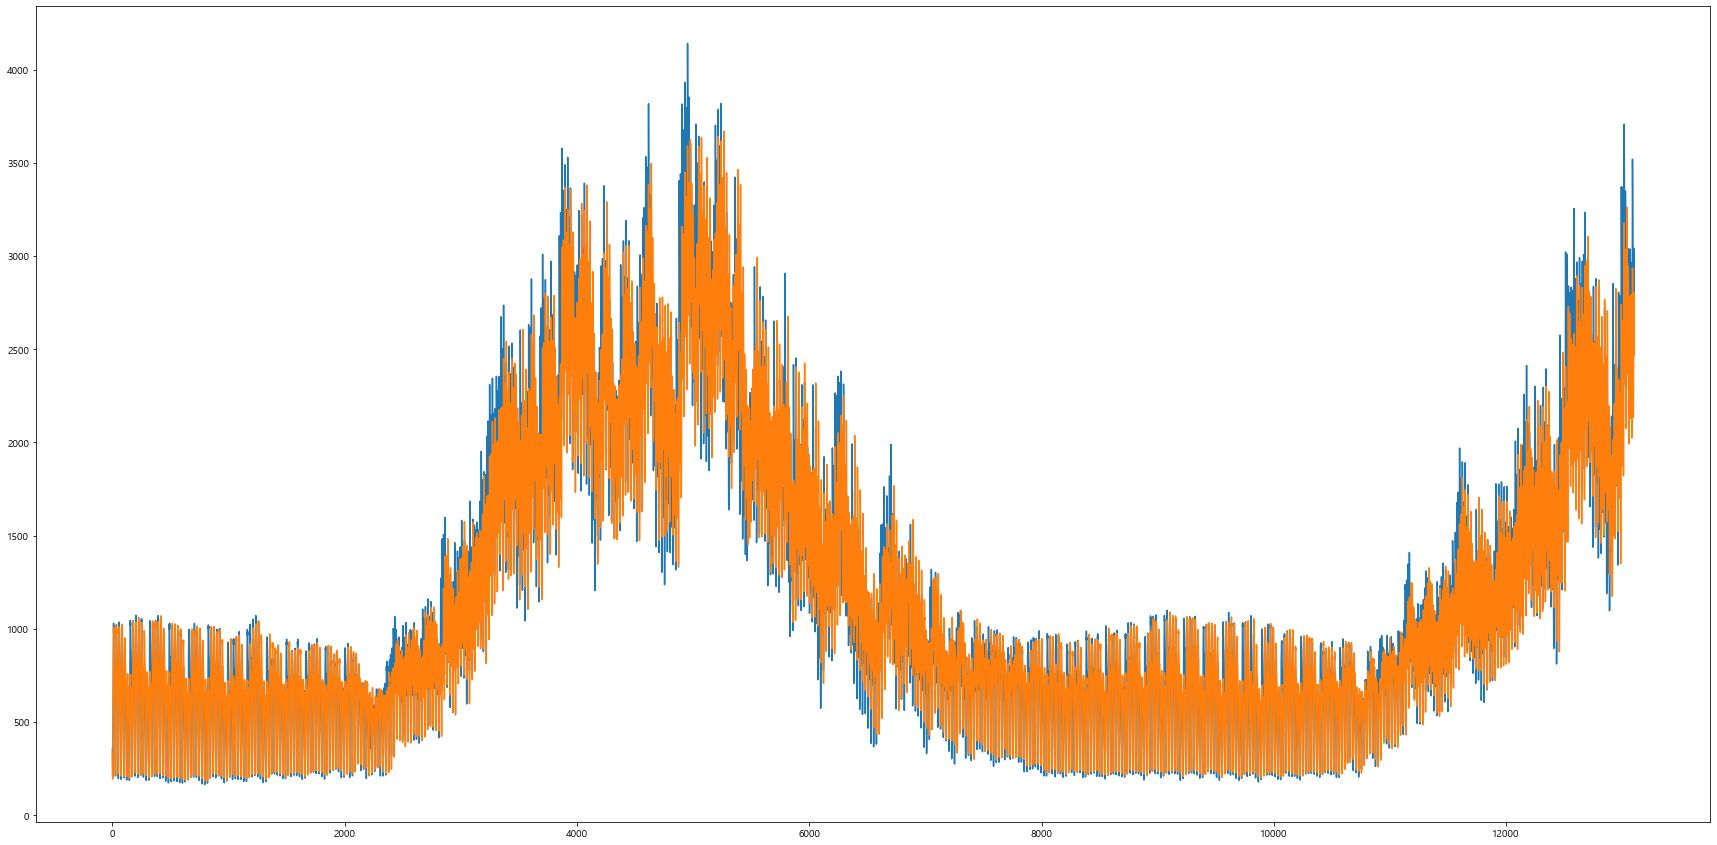

In [44]:
fig = plt.figure(figsize = (30,15))
plt.plot(np.array(y_test))
plt.plot(y_pred)

In [45]:
train_y = train.append(train.iloc[-24,:])

In [46]:
train_y = train_y.append(train_y.iloc[-24,:])
train_y

,t_24,t_168
2013-01-08 01:00:00,2491.065,2497.129
2013-01-08 02:00:00,2249.113,2363.265
2013-01-08 03:00:00,2148.961,2258.505
2013-01-08 04:00:00,2230.049,2243.969
2013-01-08 05:00:00,2456.953,2344.105
...,...,...
2018-12-31 22:00:00,2748.745,2271.333
2018-12-31 23:00:00,2685.433,2160.702
2019-01-01 00:00:00,2621.810,2075.277
2018-12-31 01:00:00,2512.497,1749.318


In [47]:
def nmae(true, pred):
#     target_idx = true_df.iloc[:,0]
#     pred_df = pred_df[pred_df.iloc[:,0].isin(target_idx)]
#     pred_df = pred_df.sort_values(by=[pred_df.columns[0]], ascending=[True])
#     true_df = true_df.sort_values(by=[true_df.columns[0]], ascending=[True])
    
#     true = true_df.iloc[:,1].to_numpy()
#     pred = pred_df.iloc[:,1].to_numpy()
    
    score = np.mean((np.abs(true-pred))/true)
    
    return score

In [48]:
# 전체 모형 만들기

In [49]:
models = []
final_df_list = []
nmae_total = 0
for supply_df in hour_time_series:
    # lag
    supply_df_24 = supply_df.shift(24)
    supply_df_168 = supply_df.shift(168)
    
    
    supply_df_reg = pd.DataFrame()
    supply_df_reg['t_24'] = supply_df_24.target
    supply_df_reg['t_168'] = supply_df_168.target
    supply_df_reg['y'] = supply_df.target
    
    supply_df_reg_final = supply_df_reg.dropna()
    final_df_list.append(supply_df_reg_final)
    #train, test data
    train, test = supply_df_reg_final.iloc[:, :-1],  supply_df_reg_final.iloc[:, -1:]
    X_train, X_test, y_train, y_test = train_test_split(train, test, shuffle=False, test_size=.25)
    # model
    lr_model = LinearRegression(fit_intercept=True)
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(X_test)
    #score
    print(f"r2_score : {r2_score(y_test, y_pred)}")
    print(f"MAPE : {MAPE(y_test, y_pred)[0]}") 
    print(f"nmae : {nmae(y_test, y_pred)[0]}", end="\n\n") 
    print(f"Coef : {lr_model.coef_[0]}", end="\n\n") 
    
    nmae_total += nmae(y_test, y_pred)
    models.append(lr_model) 

r2_score : 0.9500824008377665
MAPE : 9.521575878223603
nmae : 0.09521575878223602

Coef : [0.75077859 0.2319075 ]

r2_score : 0.962334835755121
MAPE : 9.757659141504847
nmae : 0.09757659141504847

Coef : [0.78257289 0.20230983]

r2_score : 0.9659523159275287
MAPE : 4.671203268213707
nmae : 0.04671203268213706

Coef : [0.79395932 0.18769707]

r2_score : 0.9670790385513005
MAPE : 9.788756430906862
nmae : 0.09788756430906861

Coef : [0.80259787 0.18327591]

r2_score : 0.9653497285574988
MAPE : 7.99335958486844
nmae : 0.0799335958486844

Coef : [0.82023847 0.16556585]

r2_score : 0.9341459935678391
MAPE : 9.228458158044065
nmae : 0.09228458158044064

Coef : [0.66063936 0.32053374]

r2_score : 0.9686165310402263
MAPE : 8.594310957666396
nmae : 0.08594310957666396

Coef : [0.80764658 0.17843917]



In [50]:
nmae_total / 7

y    0.085079
dtype: float64

In [51]:
#test

In [52]:
test_init = pd.read_csv('test.csv', delimiter=' ')
test_init

,일자,시간,구분
0,2019-01-01,1,A
1,2019-01-01,2,A
2,2019-01-01,3,A
3,2019-01-01,4,A
4,2019-01-01,5,A
...,...,...,...
15115,2019-03-31,20,H
15116,2019-03-31,21,H
15117,2019-03-31,22,H
15118,2019-03-31,23,H


In [53]:
def datetime_revise_test(df):
    df = df.copy()
    # python datetime에서는 시간을 0~23시까지밖에 인식을 못하기 때문에 1을 빼준다.
    df.index = pd.to_datetime(df['일자']) + pd.to_timedelta(df['시간'], unit='hours')
    
    return df

In [54]:
test = datetime_revise_test(test_init)
test

,일자,시간,구분
2019-01-01 01:00:00,2019-01-01,1,A
2019-01-01 02:00:00,2019-01-01,2,A
2019-01-01 03:00:00,2019-01-01,3,A
2019-01-01 04:00:00,2019-01-01,4,A
2019-01-01 05:00:00,2019-01-01,5,A
...,...,...,...
2019-03-31 20:00:00,2019-03-31,20,H
2019-03-31 21:00:00,2019-03-31,21,H
2019-03-31 22:00:00,2019-03-31,22,H
2019-03-31 23:00:00,2019-03-31,23,H


In [55]:
def make_df_test(df, colname):
    df = df.copy()
    df = df.query(f'구분 == "{colname}"')
    return df

In [56]:
test_time_series = [make_df_test(test, col) for col in colname]
len(test_time_series)

7

In [57]:
test_time_series[0].head()

,일자,시간,구분
2019-01-01 01:00:00,2019-01-01,1,A
2019-01-01 02:00:00,2019-01-01,2,A
2019-01-01 03:00:00,2019-01-01,3,A
2019-01-01 04:00:00,2019-01-01,4,A
2019-01-01 05:00:00,2019-01-01,5,A


## A사 test model

In [58]:
A_test_df = pd.DataFrame(columns = ["t_24", "t_168", "y"], index=test_time_series[0].index)
len(A_test_df)

2160

In [59]:
A_test_final = A_df_reg_final.append(A_test_df)
A_test_final[-2165:].head(15)

,t_24,t_168,y
2018-12-31 20:00:00,2965.860,2418.847,3040.868
2018-12-31 21:00:00,2877.140,2366.832,2973.577
2018-12-31 22:00:00,2748.745,2271.333,2840.272
2018-12-31 23:00:00,2685.433,2160.702,2692.385
2019-01-01 00:00:00,2621.810,2075.277,2583.340
2019-01-01 01:00:00,NaN,NaN,NaN
2019-01-01 02:00:00,NaN,NaN,NaN
2019-01-01 03:00:00,NaN,NaN,NaN
2019-01-01 04:00:00,NaN,NaN,NaN
2019-01-01 05:00:00,NaN,NaN,NaN


In [60]:
print(models[0].coef_, models[0].intercept_)
for i in range(len(A_test_df), 0, -1):
    t_24 = A_test_final.iloc[-i-24, -1]
    t_168 = A_test_final.iloc[-i-168, -1]
    
    
#     t_24 = A_test_final.iloc[-i-24].name
#     t_168 = A_test_final.iloc[-i-168].name
    
    A_test_final.iloc[-i, 0] = t_24
    A_test_final.iloc[-i, 1] = t_168
    for_pred = np.array(A_test_final.iloc[-i][:-1]).reshape(1, -1)
#     print(for_pred)
    
    # A사의 lr
    model = models[0]
    pred = model.predict(for_pred)[-1]
    
    A_test_final.iloc[-i, -1] = pred

    
    
    
A_test_final[-2165:].head(15)

[[0.75077859 0.2319075 ]] [16.70728345]


,t_24,t_168,y
2018-12-31 20:00:00,2965.860,2418.847,3040.868000
2018-12-31 21:00:00,2877.140,2366.832,2973.577000
2018-12-31 22:00:00,2748.745,2271.333,2840.272000
2018-12-31 23:00:00,2685.433,2160.702,2692.385000
2019-01-01 00:00:00,2621.810,2075.277,2583.340000
2019-01-01 01:00:00,2429.750,1939.174,2290.620568
2019-01-01 02:00:00,2228.795,1738.761,2093.270577
2019-01-01 03:00:00,2120.860,1580.520,1975.538015
2019-01-01 04:00:00,2162.415,1579.027,2006.390382
2019-01-01 05:00:00,2335.875,1678.272,2159.636097


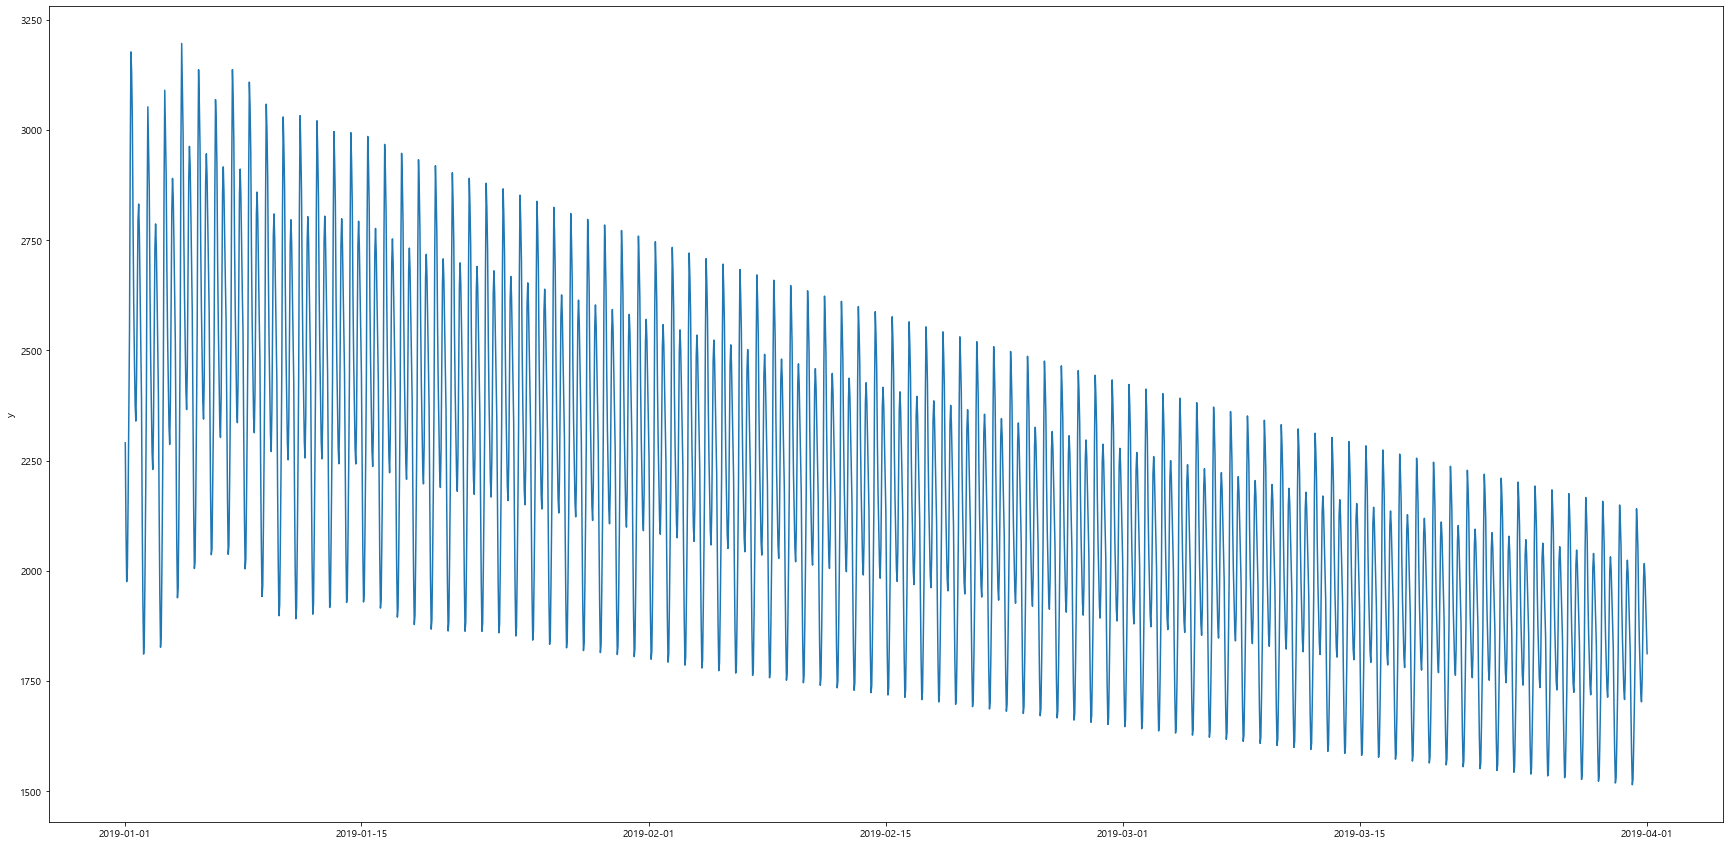

In [74]:
fig = plt.figure(figsize=(30,15))
sns.lineplot(data=A_test_final[-2160:], x=A_test_final[-2160:].index, y='y')
fig.show()

In [62]:
A_test_final[-2160:]['y'].values
a_tmp = test_init.query("구분 == 'A'")

In [63]:

a_tmp['공급량'] = A_test_final[-2160:]['y'].values

In [64]:
a_tmp

,일자,시간,구분,공급량
0,2019-01-01,1,A,2290.620568
1,2019-01-01,2,A,2093.270577
2,2019-01-01,3,A,1975.538015
3,2019-01-01,4,A,2006.390382
4,2019-01-01,5,A,2159.636097
...,...,...,...,...
2155,2019-03-31,20,A,2016.714062
2156,2019-03-31,21,A,1986.551232
2157,2019-03-31,22,A,1927.181029
2158,2019-03-31,23,A,1865.656387


## 모든 공급사

In [65]:
#채워줄 test
test_df_list = [pd.DataFrame(columns = ["t_24", "t_168", "y"], index=tmp_df.index) for tmp_df in test_time_series]
test_df_list[0]

    
    
    

,t_24,t_168,y
2019-01-01 01:00:00,NaN,NaN,NaN
2019-01-01 02:00:00,NaN,NaN,NaN
2019-01-01 03:00:00,NaN,NaN,NaN
2019-01-01 04:00:00,NaN,NaN,NaN
2019-01-01 05:00:00,NaN,NaN,NaN
...,...,...,...
2019-03-31 20:00:00,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN


In [66]:
# 마지막 2160개 제출용을 기존 데이터와 병합(for 예측)
test_df_final = [final_df.append(test_df) for final_df, test_df in zip(final_df_list, test_df_list)]
test_df_final[0]

,t_24,t_168,y
2013-01-08 01:00:00,2491.065,2497.129,2524.977
2013-01-08 02:00:00,2249.113,2363.265,2255.009
2013-01-08 03:00:00,2148.961,2258.505,2120.113
2013-01-08 04:00:00,2230.049,2243.969,2180.161
2013-01-08 05:00:00,2456.953,2344.105,2377.865
...,...,...,...
2019-03-31 20:00:00,NaN,NaN,NaN
2019-03-31 21:00:00,NaN,NaN,NaN
2019-03-31 22:00:00,NaN,NaN,NaN
2019-03-31 23:00:00,NaN,NaN,NaN


In [67]:
results = []

for test_df, s_model in zip(test_df_final, models):
    supply_df = test_df.copy()
    for i in range(2160, 0, -1):
        t_24 = supply_df.iloc[-i-24, -1]
        t_168 = supply_df.iloc[-i-168, -1]
    #     t_24 = A_test_final.iloc[-i-24].name
        supply_df.iloc[-i, 0] = t_24
        supply_df.iloc[-i, 1] = t_168

        for_pred = np.array(supply_df.iloc[-i][:2]).reshape(1, -1)
    #     print(for_pred)

        # A사의 lr
        model = s_model
        pred = model.predict(for_pred)[-1]

        supply_df.iloc[-i, 2] = pred
        
    
    y_test = supply_df.iloc[-2160-8760:-2160-8760+2160, -2]
    pred = supply_df.iloc[-2160:, -2]
    print(f"r2_score : {r2_score(y_test, pred)}")
    print(f"MAPE : {MAPE(y_test, pred)}") 
    print(f"nmae : {nmae(y_test, pred)}", end="\n\n") 

        
    results.append(supply_df)
    print('완료')


r2_score : 0.4133424674176439
MAPE : nan
nmae : nan

완료
r2_score : 0.4492872698095689
MAPE : nan
nmae : nan

완료
r2_score : 0.35707048848828316
MAPE : nan
nmae : nan

완료
r2_score : 0.48608497747235613
MAPE : nan
nmae : nan

완료
r2_score : 0.4133303529427734
MAPE : nan
nmae : nan

완료
r2_score : 0.4280764937462048
MAPE : nan
nmae : nan

완료
r2_score : 0.4904240141984708
MAPE : nan
nmae : nan

완료


In [69]:
supply_df.iloc[-2160-8760:-2160-8760+2160, -2]
pred

2019-01-01 01:00:00    444.794000
2019-01-01 02:00:00    379.305000
2019-01-01 03:00:00    334.974000
2019-01-01 04:00:00    355.515000
2019-01-01 05:00:00    392.865000
                          ...    
2019-03-31 20:00:00    473.842225
2019-03-31 21:00:00    471.556458
2019-03-31 22:00:00    464.280806
2019-03-31 23:00:00    439.233220
2019-04-01 00:00:00    410.231665
Name: t_168, Length: 2160, dtype: float64

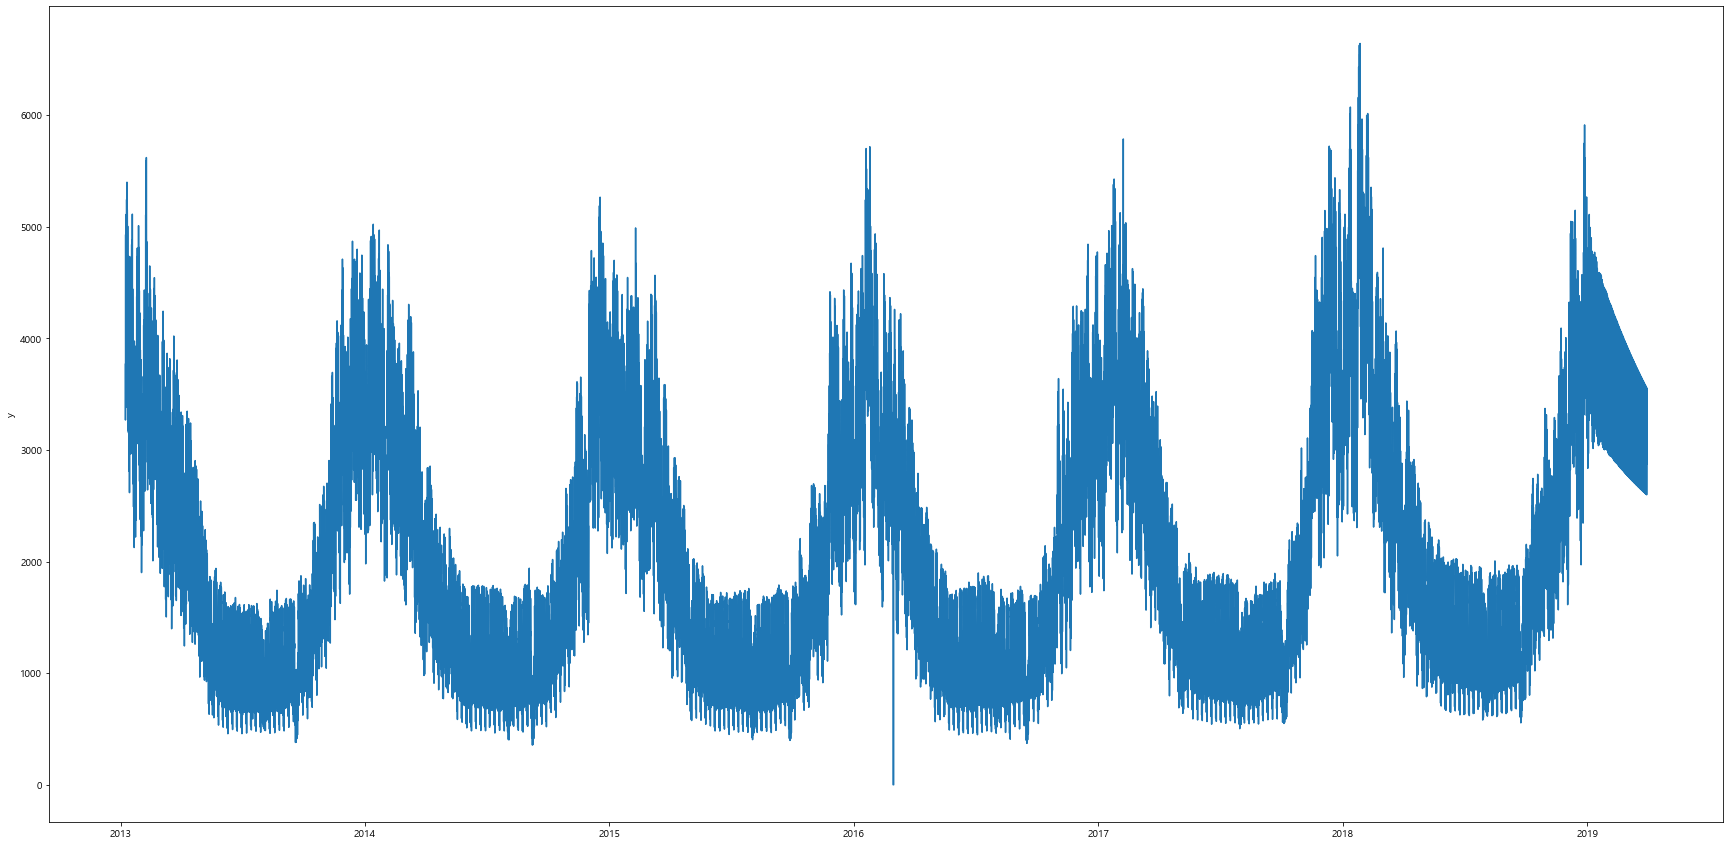

In [70]:
fig = plt.figure(figsize=(30,15))
sns.lineplot(data=results[5], x=results[5].index, y='y')
fig.show()

In [71]:
supply_name_list

['A', 'B', 'C', 'D', 'E', 'G', 'H']

In [72]:
tmp_list = []
for result, supply in zip(results, supply_name_list):

    pred_val = result[-2160:]['y'].values
    tmp = test_init.query(f"구분 == '{supply}'").copy()
    tmp['공급량'] = pred_val
    tmp_list.append(tmp)

In [73]:
final = pd.DataFrame(columns=tmp_list[0].columns)
for tmp in tmp_list:
    final = final.append(tmp)
final.__len__()

15120

In [222]:
final

,일자,시간,구분,공급량
0,2019-01-01,1,A,1215.496958
1,2019-01-01,2,A,1355.849019
2,2019-01-01,3,A,1467.927790
3,2019-01-01,4,A,1562.317330
4,2019-01-01,5,A,1640.080445
...,...,...,...,...
15115,2019-03-31,20,H,529.584043
15116,2019-03-31,21,H,523.888196
15117,2019-03-31,22,H,460.109626
15118,2019-03-31,23,H,430.103979


In [221]:
len(test_init)

15120

In [236]:
test_data = pd.read_csv('test.csv')
test_data['공급량'] = final['공급량']
test_data

,일자 시간 구분,공급량
0,2019-01-01 01 A,1215.496958
1,2019-01-01 02 A,1355.849019
2,2019-01-01 03 A,1467.927790
3,2019-01-01 04 A,1562.317330
4,2019-01-01 05 A,1640.080445
...,...,...
15115,2019-03-31 20 H,529.584043
15116,2019-03-31 21 H,523.888196
15117,2019-03-31 22 H,460.109626
15118,2019-03-31 23 H,430.103979


In [237]:
test_data.to_csv('submission_LR.csv', index=False)